In [1]:
import torch
import matplotlib.pyplot as plt
from modules.data.datamanager import CityScapesDataManagerConfig, CityScapesDataManager

/mundus/oojekanmi522/miniconda3/envs/cityscapes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datamanager_config = CityScapesDataManagerConfig(
    images_dir = "datasets/images/leftImg8bit/", 
    labels_dir = "datasets/labels/gtFine", 
    image_size = (1024, 2048),
    batch_size = 4,
    shuffle = True
)
datamanager = CityScapesDataManager(datamanager_config)
train_dataset = datamanager.get_train_dataset()
valid_dataset = datamanager.get_valid_dataset()
test_dataset = datamanager.get_test_dataset()
train_dataloader = datamanager.get_train_dataloader()
valid_dataloader = datamanager.get_valid_dataloader()
test_dataloader = datamanager.get_test_dataloader()

# 1. Initial Analysis - Exploratory Data Analysis

### 1.1. Visualize Dataset Distributions

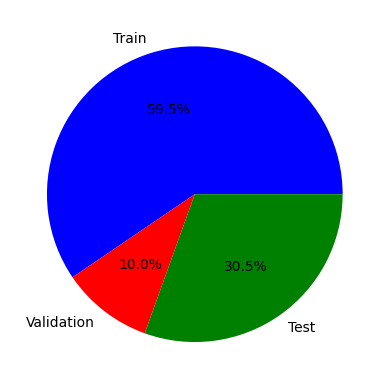

In [3]:
labels = ["Train", "Validation", "Test"]
sizes = [len(train_dataset), len(valid_dataset), len(test_dataset)]
pie_output = plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['b', 'r', 'g'])

### 1.2. Visualize sample images and their masks

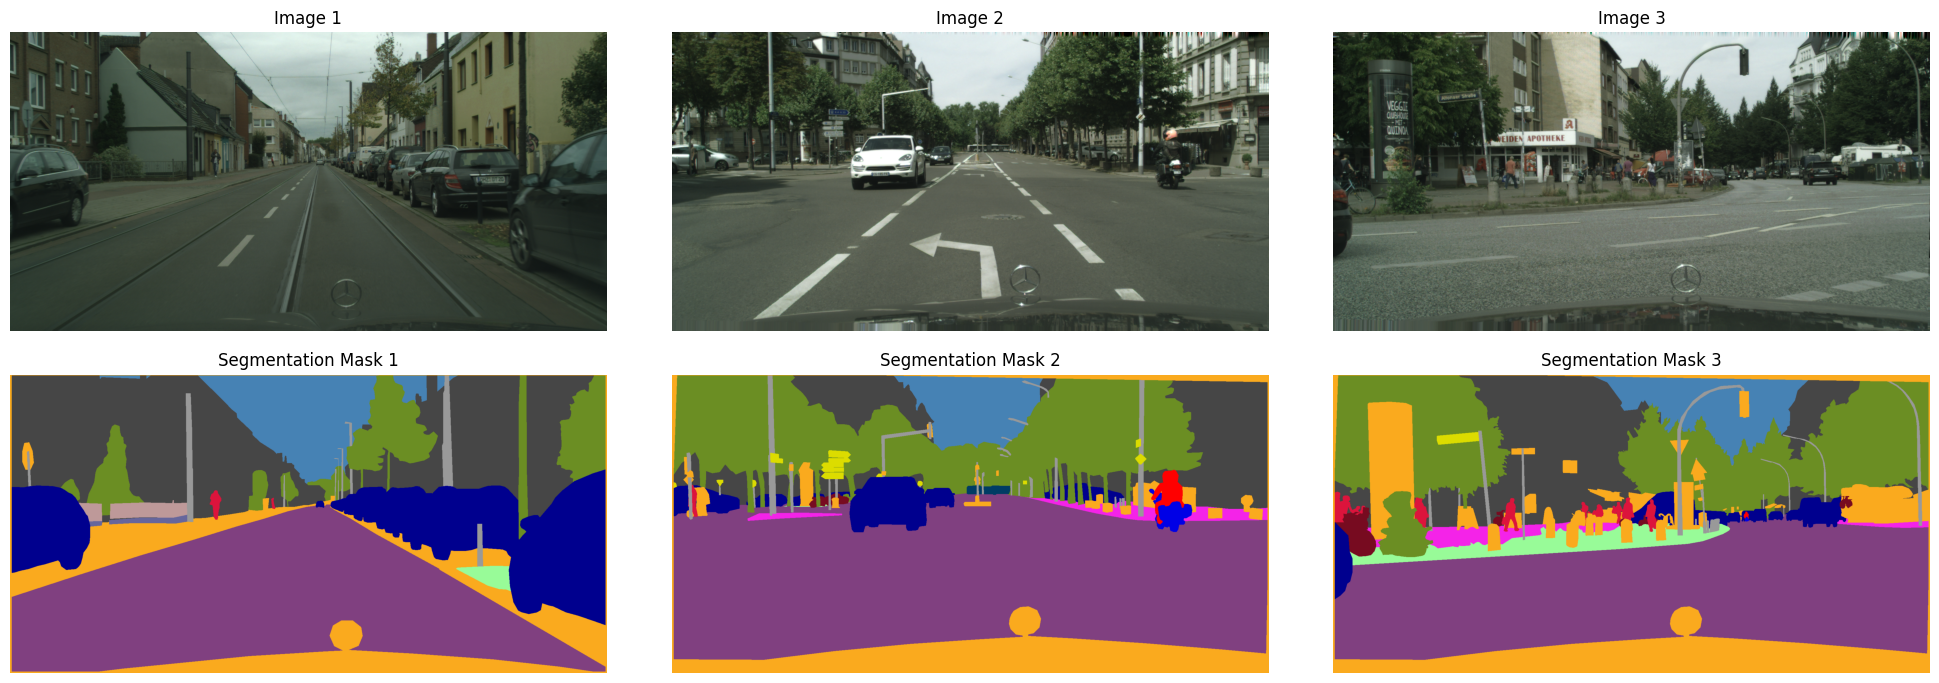

In [4]:
# # Get sample data
sample_images, sample_labels = next(iter(train_dataloader))

fig, axis = plt.subplots(2,3, figsize=(20,7))
plt.tight_layout()
plots = [sample_images, sample_labels]
idx = [0,5,10]
for j in range(3):
    axis[0,j].imshow(sample_images[j].permute(1,2,0).numpy())
    axis[0,j].axis("off")
    axis[0,j].set_title(f"Image {j+1}")
    axis[1,j].imshow(train_dataset.decode_mask(sample_labels[j]).numpy())
    axis[1,j].axis("off")
    axis[1,j].set_title(f"Segmentation Mask {j+1}")


### 1.3. Class Imbalance 1 - Image Analysis (How many images does each class appear?)

In [5]:
classes_id = list(train_dataset.valid_label_ids.values()) + [train_dataset.ignore_index]
classes_id, len(classes_id)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 20)

In [6]:
def get_class_masks_stat(dataloader):
    class_num_images = torch.zeros(len(classes_id))
    class_pixels = torch.zeros(len(classes_id))

    for _, masks in dataloader:
        for mask in masks:
            idx = mask.unique()
            idx[idx == train_dataset.ignore_index] = -1
            class_num_images[idx] += 1
            class_pixels += torch.tensor([torch.where(mask==class_id, 1, 0).sum().item() for class_id in classes_id])
        
    avg_class_pixels = class_pixels/(class_num_images.sum() + 1e-16)

    return class_num_images, avg_class_pixels


In [7]:
train_class_num_images, train_avg_class_pixels = get_class_masks_stat(train_dataloader)
valid_class_num_images, valid_avg_class_pixels = get_class_masks_stat(valid_dataloader)

In [12]:
labels = list(train_dataset.valid_label_names.values()) 
labels

['road',
 'sidewalk',
 'building',
 'wall',
 'fence',
 'pole',
 'traffic light',
 'traffic sign',
 'vegetation',
 'terrain',
 'sky',
 'person',
 'rider',
 'car',
 'truck',
 'bus',
 'train',
 'motorcycle',
 'bicycle']

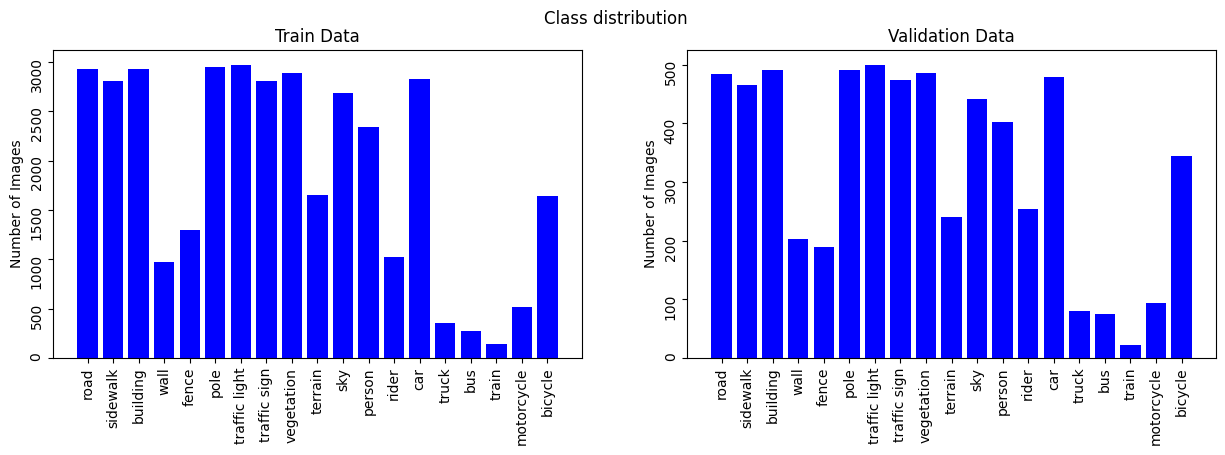

In [13]:
# labels = train_data.class_names
color = ['blue' for i in range(20)]
fig, axis = plt.subplots(1,2, figsize=(15,4))
plt.suptitle("Class distribution")

axis[0].bar(labels, train_class_num_images[:-1], color=color)
axis[0].set_ylabel("Number of Images")
axis[0].set_title("Train Data")
axis[0].tick_params(labelrotation=90)
axis[1].bar(labels, valid_class_num_images[:-1], color=color)
axis[1].set_ylabel("Number of Images")
axis[1].set_title("Validation Data")
axis[1].tick_params(rotation=90)

### 1.3. Class Imbalance 2 - Pixel Analysis (Average pixels does each class have in total?)

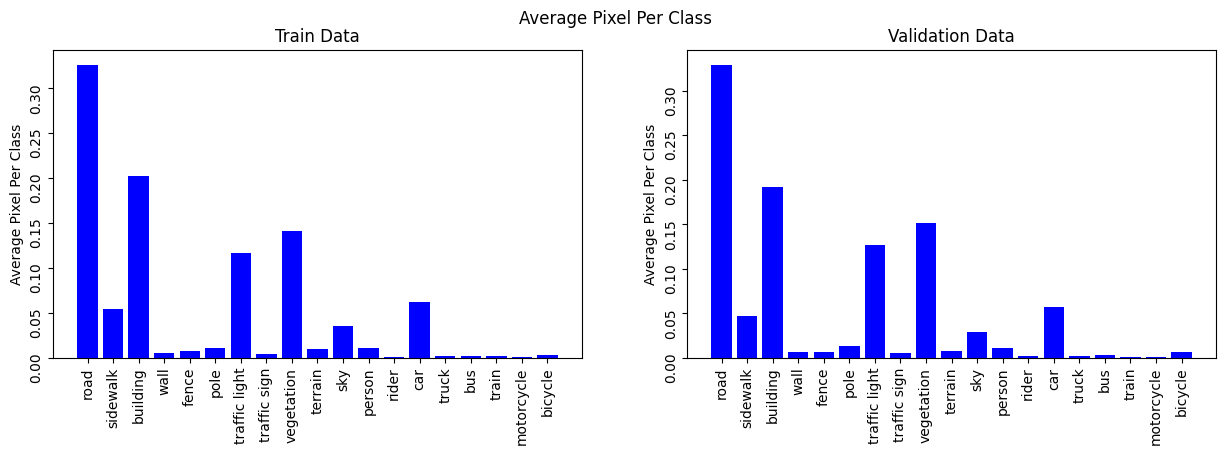

In [14]:
fig, axis = plt.subplots(1, 2, figsize=(15,4))
plt.suptitle("Average Pixel Per Class")

axis[0].bar(labels, train_avg_class_pixels[:-1]/train_avg_class_pixels[:-1].sum(), color=color)
axis[0].set_ylabel("Average Pixel Per Class")
axis[0].set_title("Train Data")
axis[0].tick_params(labelrotation=90)
axis[1].bar(labels, valid_avg_class_pixels[:-1]/valid_avg_class_pixels[:-1].sum(), color=color)
axis[1].set_ylabel("Average Pixel Per Class")
axis[1].set_title("Validation Data")
axis[1].tick_params(rotation=90)